In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn shap xgboost


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import shap
import warnings

warnings.filterwarnings("ignore")

# Load datasets
datasets_path = "./datasets/"
train = pd.read_csv(f"{datasets_path}train.csv")
test = pd.read_csv(f"{datasets_path}test.csv")
misconception_mapping = pd.read_csv(f"{datasets_path}misconception_mapping.csv")

# Display basic information about the datasets
print("Train Dataset Info:")
print(train.info())
print("\nTest Dataset Info:")
print(test.info())


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QuestionId        1869 non-null   int64  
 1   ConstructId       1869 non-null   int64  
 2   ConstructName     1869 non-null   object 
 3   SubjectId         1869 non-null   int64  
 4   SubjectName       1869 non-null   object 
 5   CorrectAnswer     1869 non-null   object 
 6   QuestionText      1869 non-null   object 
 7   AnswerAText       1869 non-null   object 
 8   AnswerBText       1869 non-null   object 
 9   AnswerCText       1869 non-null   object 
 10  AnswerDText       1869 non-null   object 
 11  MisconceptionAId  1135 non-null   float64
 12  MisconceptionBId  1118 non-null   float64
 13  MisconceptionCId  1080 non-null   float64
 14  MisconceptionDId  1037 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 219.2+ KB
None

Test

In [3]:
# Remove duplicates
train.drop_duplicates(inplace=True)

# Drop rows with missing values in misconception columns
misconception_cols = ["MisconceptionAId", "MisconceptionBId", "MisconceptionCId"]
train.dropna(subset=misconception_cols, inplace=True)

# Combine text features into a single column
train["CombinedText"] = (
    train["QuestionText"]
    + " "
    + train["AnswerAText"]
    + " "
    + train["AnswerBText"]
    + " "
    + train["AnswerCText"]
    + " "
    + train["AnswerDText"]
)
test["CombinedText"] = (
    test["QuestionText"]
    + " "
    + test["AnswerAText"]
    + " "
    + test["AnswerBText"]
    + " "
    + test["AnswerCText"]
    + " "
    + test["AnswerDText"]
)

# Display the first few rows of the updated train and test datasets
print("Sample from Train Dataset:")
print(train.head())

print("\nSample from Test Dataset:")
print(test.head())


Sample from Train Dataset:
    QuestionId  ConstructId  \
1            1         1612   
5            5         2052   
11          11         2456   
14          14         1505   
16          16          695   

                                        ConstructName  SubjectId  \
1   Simplify an algebraic fraction by factorising ...       1077   
5                             Identify a unit of area         75   
11                    Identify the net of a non-prism         85   
14  Select the correct answer to an iteration ques...         69   
16  Divide a quantity into two parts for a given a...        241   

                                    SubjectName CorrectAnswer  \
1               Simplifying Algebraic Fractions             D   
5                         Area of Simple Shapes             D   
11                                         Nets             D   
14  Trial and Improvement and Iterative Methods             D   
16                           Sharing in a Ratio     

In [4]:
# Balance the classes for each misconception column
balanced_dfs = []
for col in misconception_cols:
    majority_class = train[train[col] == 0]
    minority_class = train[train[col] != 0]

    if len(minority_class) > 0 and len(majority_class) > len(minority_class):
        # Oversample the minority class
        minority_oversampled = resample(
            minority_class,
            replace=True,
            n_samples=len(majority_class),  # Match majority size
            random_state=42,
        )
        balanced_dfs.append(pd.concat([majority_class, minority_oversampled]))
    else:
        balanced_dfs.append(train)

# Combine all balanced datasets
train_balanced = pd.concat(balanced_dfs).drop_duplicates()

# Verify class distribution for each column
for col in misconception_cols:
    print(f"Class distribution for {col} after balancing:\n", train_balanced[col].value_counts())


Class distribution for MisconceptionAId after balancing:
 MisconceptionAId
1379.0    4
1898.0    3
1214.0    3
220.0     3
1876.0    3
         ..
2292.0    1
132.0     1
1554.0    1
1896.0    1
747.0     1
Name: count, Length: 183, dtype: int64
Class distribution for MisconceptionBId after balancing:
 MisconceptionBId
1248.0    4
1990.0    3
2355.0    2
2539.0    2
433.0     2
         ..
1973.0    1
375.0     1
730.0     1
1046.0    1
1731.0    1
Name: count, Length: 190, dtype: int64
Class distribution for MisconceptionCId after balancing:
 MisconceptionCId
1214.0    5
1383.0    3
1379.0    3
458.0     3
91.0      2
         ..
247.0     1
443.0     1
2208.0    1
1055.0    1
1585.0    1
Name: count, Length: 190, dtype: int64


In [5]:
# Define features and target variables
X = train_balanced["CombinedText"]
y = train_balanced[misconception_cols]

# Perform train-test split (no stratification for simplicity)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the sizes of training and validation sets
print(f"Training data size: {X_train.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")


Training data size: 173
Validation data size: 44


In [6]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

# Fit the vectorizer on training data and transform training and validation sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Display the shape of the resulting TF-IDF matrices
print(f"TF-IDF training matrix shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation matrix shape: {X_val_tfidf.shape}")


TF-IDF training matrix shape: (173, 767)
TF-IDF validation matrix shape: (44, 767)


In [8]:
from sklearn.multioutput import MultiOutputClassifier

# Define models
models = {
    "Random Forest": MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    "Gradient Boosting": MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=42)),
    "Logistic Regression": MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42)),
}

# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)  # Train the model
    trained_models[name] = model
    print(f"{name} training completed.")


Training Random Forest...
Random Forest training completed.
Training Gradient Boosting...
Gradient Boosting training completed.
Training Logistic Regression...
Logistic Regression training completed.


In [9]:
# Evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize results storage
results = []

for name, model in trained_models.items():
    print(f"Evaluating {name}...")
    
    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate metrics for each output label
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for col_idx, col_name in enumerate(misconception_cols):
        acc = accuracy_score(y_val.iloc[:, col_idx], y_pred[:, col_idx])
        prec = precision_score(y_val.iloc[:, col_idx], y_pred[:, col_idx], average="weighted", zero_division=0)
        rec = recall_score(y_val.iloc[:, col_idx], y_pred[:, col_idx], average="weighted", zero_division=0)
        f1 = f1_score(y_val.iloc[:, col_idx], y_pred[:, col_idx], average="weighted", zero_division=0)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    # Average metrics across all output labels
    results.append({
        "Model": name,
        "Accuracy": np.mean(accuracies),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1 Score": np.mean(f1_scores),
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance:")
print(results_df)


Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...

Model Performance:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.037879   0.041667  0.037879  0.037879
1    Gradient Boosting  0.045455   0.035173  0.045455  0.037247
2  Logistic Regression  0.015152   0.002715  0.015152  0.004157


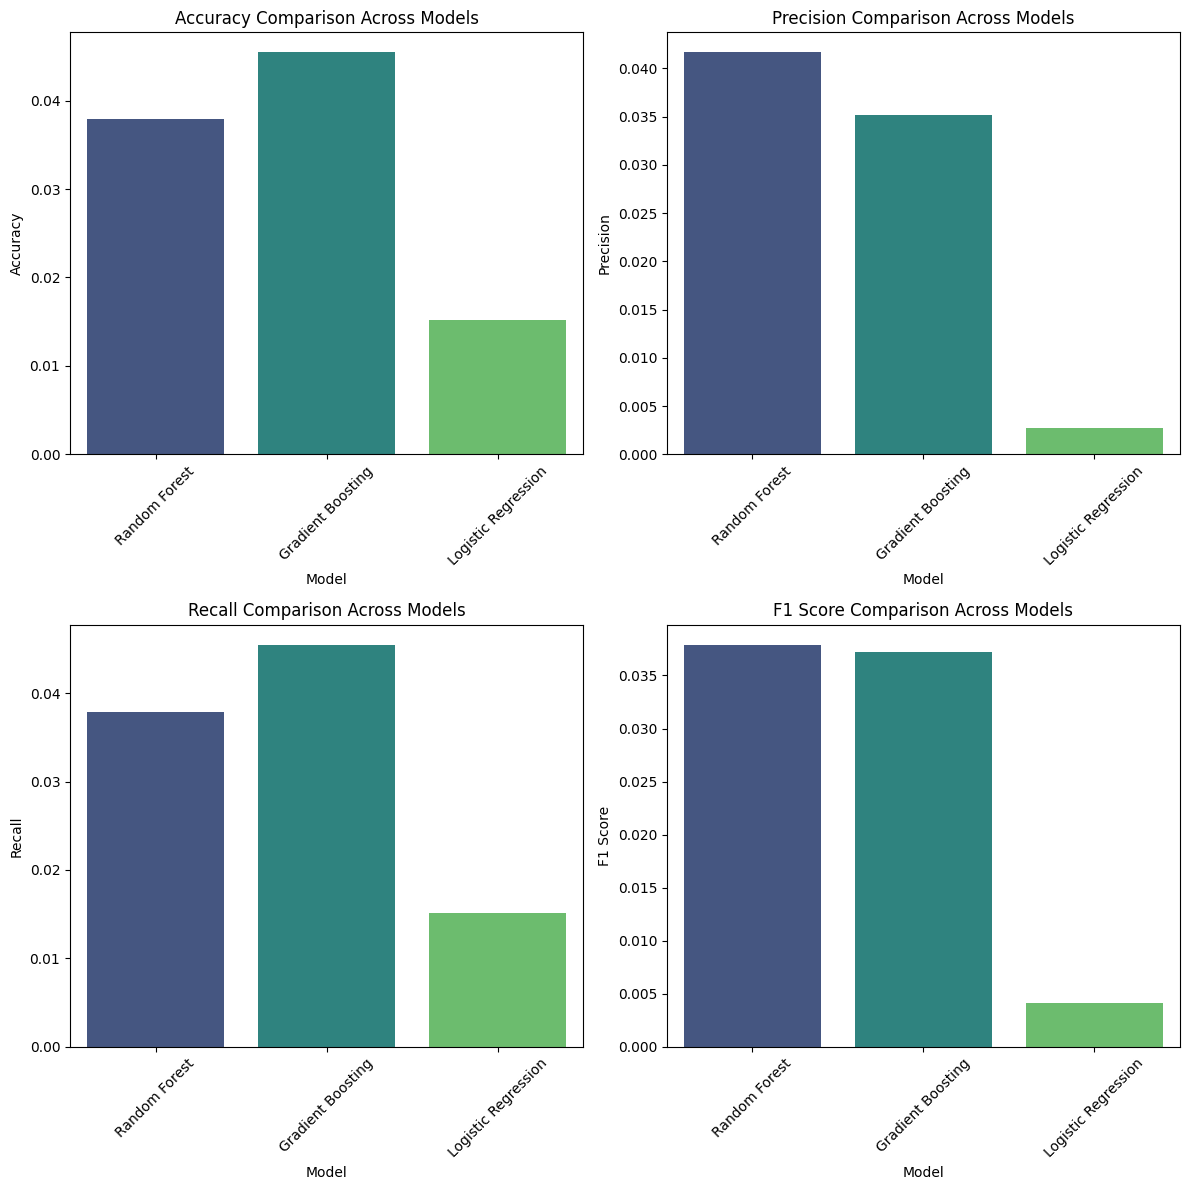

In [10]:
# Visualize model performance
import matplotlib.pyplot as plt
import seaborn as sns

# Define metrics to visualize
metrics_list = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, metric in enumerate(metrics_list):
    sns.barplot(
        x="Model", 
        y=metric, 
        data=results_df, 
        ax=axes[i // 2, i % 2], 
        palette="viridis"
    )
    axes[i // 2, i % 2].set_title(f"{metric} Comparison Across Models")
    axes[i // 2, i % 2].set_ylabel(metric)
    axes[i // 2, i % 2].set_xlabel("Model")
    axes[i // 2, i % 2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Confusion Matrix for Random Forest - MisconceptionAId


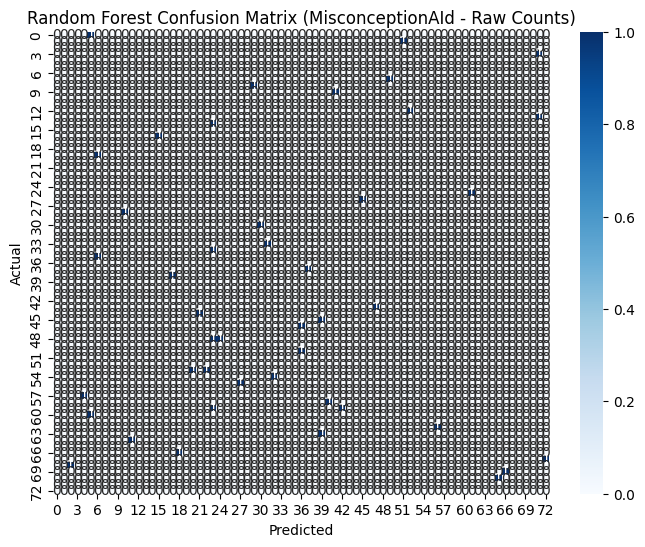

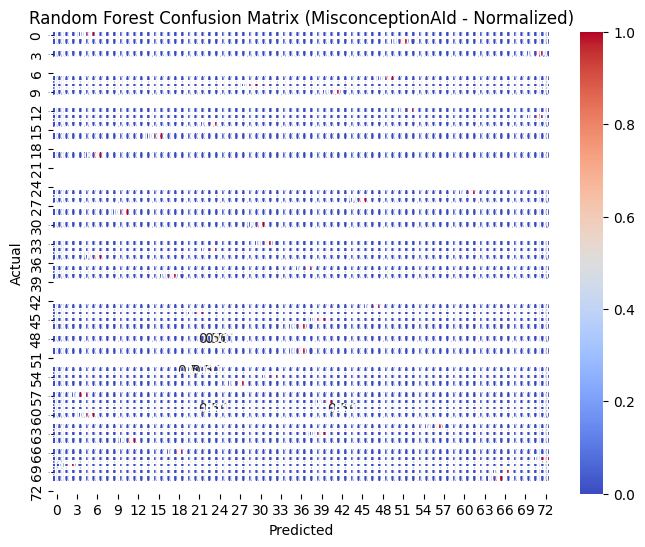

Confusion Matrix for Gradient Boosting - MisconceptionAId


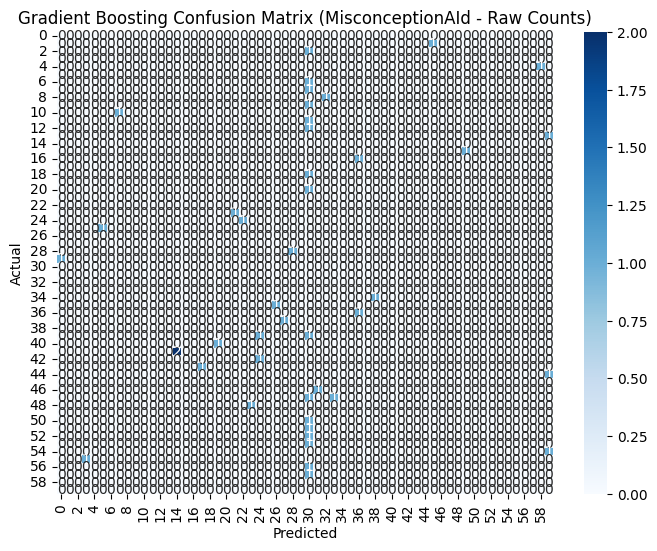

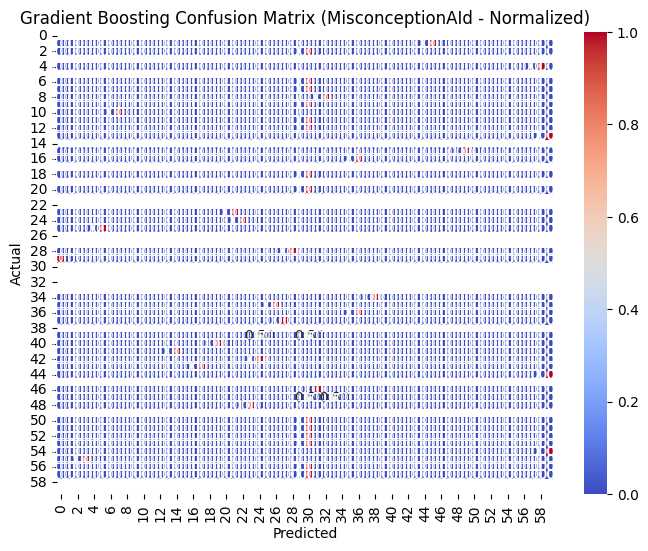

Confusion Matrix for Logistic Regression - MisconceptionAId


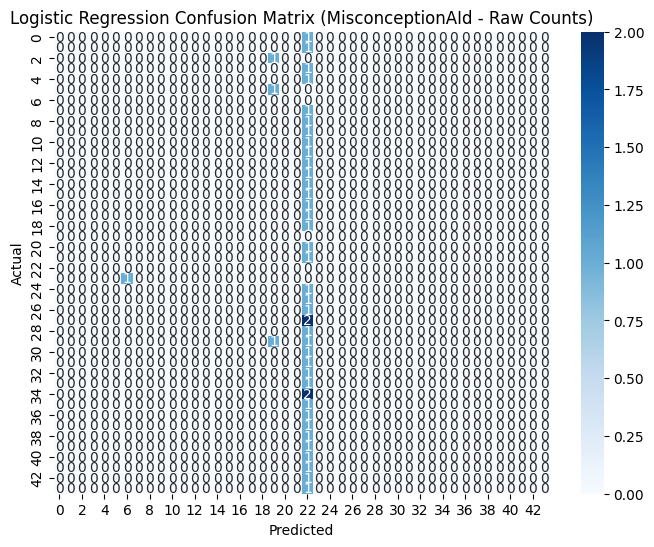

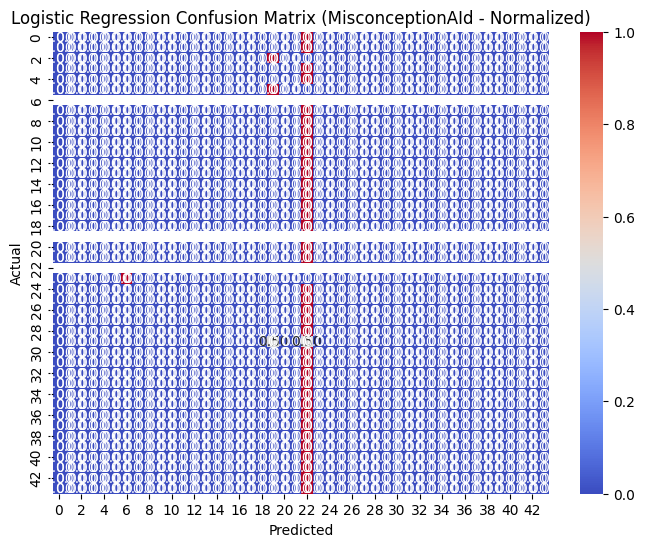

In [11]:
# Confusion matrix for MisconceptionAId
label_idx = 0  # Index for 'MisconceptionAId'

for name, model in trained_models.items():
    print(f"Confusion Matrix for {name} - MisconceptionAId")

    # Predict on validation data for MisconceptionAId
    y_pred = model.predict(X_val_tfidf)
    cm = confusion_matrix(y_val.iloc[:, label_idx], y_pred[:, label_idx])
    
    # Plot raw confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"{name} Confusion Matrix (MisconceptionAId - Raw Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Normalize confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"{name} Confusion Matrix (MisconceptionAId - Normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Simplified Confusion Matrix for Random Forest - MisconceptionAId


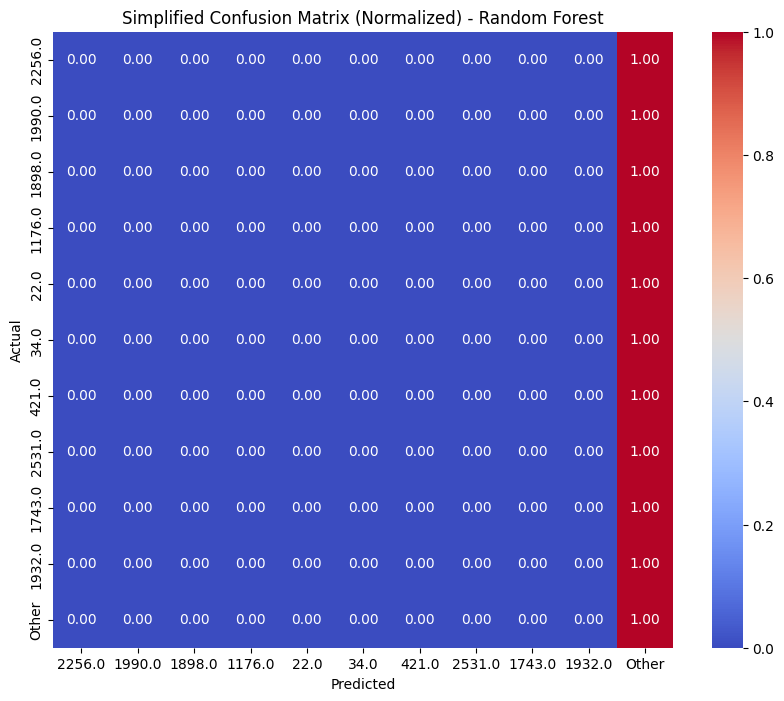

Simplified Confusion Matrix for Gradient Boosting - MisconceptionAId


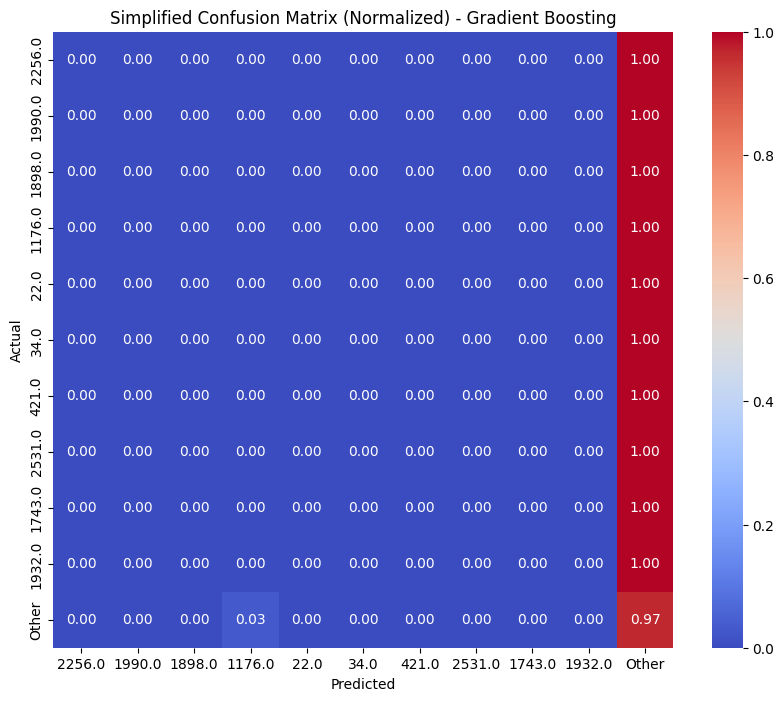

Simplified Confusion Matrix for Logistic Regression - MisconceptionAId


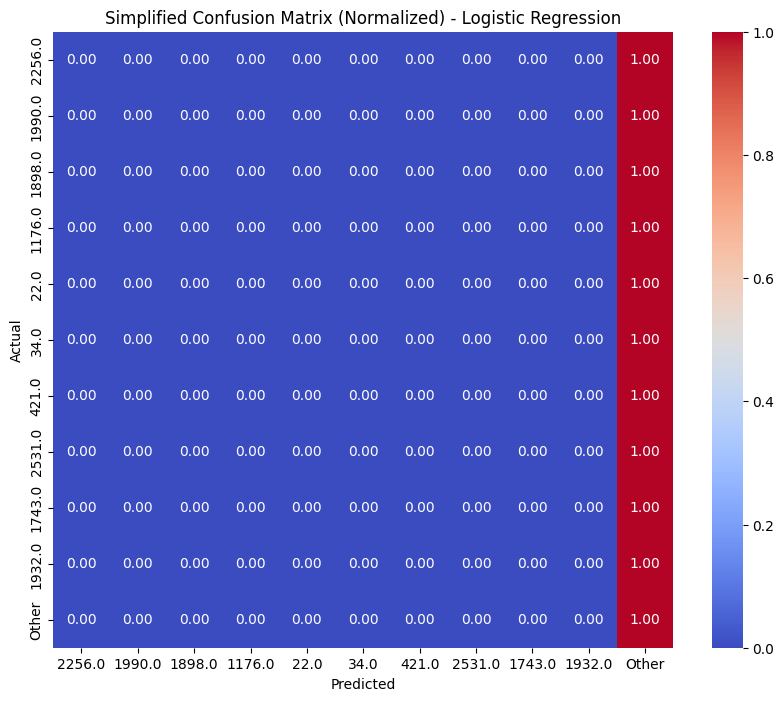

In [12]:
# Simplify confusion matrix visualization by focusing on top N classes
top_n_classes = 10  # Number of top classes to focus on (adjust as needed)

for name, model in trained_models.items():
    print(f"Simplified Confusion Matrix for {name} - MisconceptionAId")

    # Predict on validation data for MisconceptionAId
    y_pred = model.predict(X_val_tfidf)

    # Get the top N most frequent classes in the validation set
    top_classes = y_val.iloc[:, 0].value_counts().index[:top_n_classes]

    # Map other classes to "Other"
    y_val_filtered = y_val.iloc[:, 0].apply(lambda x: x if x in top_classes else -1)
    y_pred_filtered = pd.Series(y_pred[:, 0]).apply(lambda x: x if x in top_classes else -1)

    # Compute the confusion matrix for filtered classes
    cm = confusion_matrix(y_val_filtered, y_pred_filtered, labels=list(top_classes) + [-1])

    # Define class labels
    class_labels = list(top_classes) + ["Other"]

    # Plot normalized confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Simplified Confusion Matrix (Normalized) - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
# SHAP analysis for Random Forest model (or another model of your choice)
best_model_name = "Random Forest"  # You can change this to "Logistic Regression" if needed
best_model = trained_models[best_model_name]

# Use the first estimator in the MultiOutputClassifier as SHAP requires a single model
rf_model = best_model.estimators_[0]

# Convert sparse matrix to dense for SHAP
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()

# Generate SHAP values
explainer = shap.Explainer(rf_model, X_train_tfidf_dense)
shap_values = explainer(X_val_tfidf_dense)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_val_tfidf_dense, feature_names=vectorizer.get_feature_names_out())


 22%|====                | 1433/6644 [00:15<00:54]       

In [ ]:
# # SHAP analysis for Logistic Regression model
# best_model_name = "Logistic Regression"  # Update model name if needed
# best_model = trained_models[best_model_name]

# # Convert sparse matrix to dense for SHAP
# X_train_tfidf_dense = X_train_tfidf.toarray()
# X_val_tfidf_dense = X_val_tfidf.toarray()

# # Define a wrapper function for predict_proba
# def predict_proba_shap(X):
#     # Returns the probabilities for the first target column (MisconceptionAId)
#     return best_model.estimators_[0].predict_proba(X)

# # Use SHAP KernelExplainer for Logistic Regression
# explainer = shap.KernelExplainer(predict_proba_shap, X_train_tfidf_dense[:100])  # Use a subset for KernelExplainer initialization
# shap_values = explainer.shap_values(X_val_tfidf_dense[:100])  # Calculate SHAP values on a subset for performance reasons

# # Visualize SHAP summary plot for the first output class (MisconceptionAId)
# shap.summary_plot(shap_values, X_val_tfidf_dense[:100], feature_names=vectorizer.get_feature_names_out())


In [ ]:
# # SHAP analysis for Random Forest model (MisconceptionBId)
# best_model_name = "Random Forest"
# best_model = trained_models[best_model_name]

# # Use the second estimator in the MultiOutputClassifier for MisconceptionBId
# rf_model_b = best_model.estimators_[1]  # Index 1 corresponds to MisconceptionBId

# # Convert sparse matrix to dense for SHAP
# X_train_tfidf_dense = X_train_tfidf.toarray()
# X_val_tfidf_dense = X_val_tfidf.toarray()

# # Generate SHAP values
# explainer = shap.Explainer(rf_model_b, X_train_tfidf_dense)
# shap_values = explainer(X_val_tfidf_dense)

# # Visualize SHAP summary plot for MisconceptionBId
# shap.summary_plot(shap_values, X_val_tfidf_dense, feature_names=vectorizer.get_feature_names_out())


In [ ]:
# Feature importance from Random Forest (MisconceptionAId)
best_model_name = "Random Forest"
rf_model_a = trained_models[best_model_name].estimators_[0]  # For MisconceptionAId

# Get feature importances
feature_importances = rf_model_a.feature_importances_
top_features_idx = np.argsort(feature_importances)[::-1][:10]
top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_idx]

# Display top features
print("Top 10 features contributing to MisconceptionAId predictions:")
for i, feature in enumerate(top_features):
    print(f"{i + 1}. {feature} (Importance: {feature_importances[top_features_idx[i]]:.4f})")

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feature_importances[top_features_idx][::-1], color="teal")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top 10 Features for {best_model_name} - MisconceptionAId")
plt.show()


In [ ]:
# Generate predictions for test set
test_tfidf = vectorizer.transform(test["CombinedText"])

# Predict for all models and targets
final_predictions = {}
for name, model in trained_models.items():
    print(f"Generating predictions for {name}...")
    predictions = model.predict(test_tfidf)
    for idx, col in enumerate(misconception_cols):
        final_predictions[f"{col}_{name}"] = predictions[:, idx]

# Combine predictions into a DataFrame
final_predictions_df = pd.DataFrame(final_predictions)

# Display the first few rows of predictions
print("\nFinal Predictions for Test Data:")
print(final_predictions_df.head())


In [ ]:
# Save final predictions to a CSV file
output_path = "./final_predictions.csv"
final_predictions_df.to_csv(output_path, index=False)
print(f"Final predictions saved to {output_path}")
